In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline

In [2]:
data = pd.read_json("data/augmented/merged_data.json")

In [3]:
with open("class_files/coco_classes.txt", "r") as f:
    coco_objects = [i.strip() for i in f.readlines()]
coco_objects = [i for i in coco_objects if i not in ["__background__", "N/A"]]
coco_objects = [f"object_{i}" for i in coco_objects]

with open("class_files/expression_classes.txt", "r") as f:
    expressions = [i.strip() for i in f.readlines()]
expressions = [f"expression_{i}" for i in expressions]

with open("class_files/places365_classes.txt", "r") as f:
    places = [i.strip() for i in f.readlines()]
places = [i.split(" ")[0][3:] for i in places]
places = [f"place_{i}" for i in places]

In [4]:
features = [i for inner in [coco_objects, expressions, places] for i in inner]
attributes = list(pd.read_csv("external/vpa-master/attributes.tsv", sep="\t")["attribute_id"])

In [5]:
train = data[data.dataset.isin(["train", "validation"])]
test = data[data.dataset == "test"]

X_train, y_train = train[features], train["a0_safe"]
X_test, y_test = test[features], test["a0_safe"]
X, y = data[features], data["a0_safe"]

## PCA

In [8]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

In [9]:
pipe = make_pipeline(
    PCA(2),
    DecisionTreeClassifier(max_depth=10),
)
pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

       False       0.83      0.88      0.86      4994
        True       0.78      0.70      0.74      3006

    accuracy                           0.81      8000
   macro avg       0.81      0.79      0.80      8000
weighted avg       0.81      0.81      0.81      8000



In [10]:
pca = PCA(2)
pca.fit(X)
pca.explained_variance_ratio_

array([0.6703972 , 0.19906276])

In [11]:
comp = pd.DataFrame(
    pca.components_,
    columns=X_train.columns
)

In [12]:
comp.sort_values(0, axis=1, ascending=False)

,object_person,expression_neutral,expression_anger,expression_happiness,object_handbag,object_chair,object_umbrella,object_backpack,expression_sadness,object_tie,...,object_cake,object_vase,place_natural_history_museum,object_bowl,place_booth/indoor,object_bed,place_museum/indoor,place_archive,object_bird,object_book
0,0.699704,0.683062,0.147613,0.140253,0.028998,0.023795,0.016405,0.015241,0.013575,0.008658,...,-0.000557,-0.000674,-0.000692,-0.000723,-0.000920,-0.001120,-0.001440,-0.001567,-0.003103,-0.006162
1,-0.709500,0.688073,0.125012,0.071048,-0.033977,-0.017765,-0.012221,-0.016433,0.012737,-0.005116,...,0.000673,0.001054,0.000802,0.000611,0.000966,0.000812,0.001459,0.001702,0.003234,0.006088


In [13]:
comp.sort_values(1, axis=1, ascending=False)

,expression_neutral,expression_anger,expression_happiness,expression_sadness,object_book,object_bird,place_archive,place_museum/indoor,object_clock,object_vase,...,object_bottle,object_tie,object_bicycle,object_traffic light,object_umbrella,object_car,object_backpack,object_chair,object_handbag,object_person
0,0.683062,0.147613,0.140253,0.013575,-0.006162,-0.003103,-0.001567,-0.001440,-0.000131,-0.000674,...,0.003009,0.008658,0.004713,0.007745,0.016405,0.003383,0.015241,0.023795,0.028998,0.699704
1,0.688073,0.125012,0.071048,0.012737,0.006088,0.003234,0.001702,0.001459,0.001116,0.001054,...,-0.005090,-0.005116,-0.005580,-0.006255,-0.012221,-0.013314,-0.016433,-0.017765,-0.033977,-0.709500


In [14]:
for n in range(2, 5):
    show_pca = PCA(n)

    components = show_pca.fit_transform(X)

    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(show_pca.explained_variance_ratio_ * 100)
    }


    fig = px.scatter_matrix(
        components,
        dimensions=range(n),
        labels=labels,
        color=y
    )
    fig.update_traces(diagonal_visible=False)
    
    # uncomment (at least) one of the lines below
    # fig.write_image(f"images/pca/pca{n}.pdf")
    # fig.show()

## Log Reg with scaling

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [16]:
pipe = make_pipeline(
    StandardScaler(), 
    LogisticRegression()
)
clf = pipe
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [17]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.84      0.88      0.86      4994
        True       0.78      0.71      0.74      3006

    accuracy                           0.82      8000
   macro avg       0.81      0.80      0.80      8000
weighted avg       0.81      0.82      0.81      8000



## Tree

In [25]:
import sklearn.tree as tree

In [26]:
clf = DecisionTreeClassifier(max_depth=1)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.85      0.81      0.83      4994
        True       0.70      0.76      0.73      3006

    accuracy                           0.79      8000
   macro avg       0.78      0.79      0.78      8000
weighted avg       0.80      0.79      0.79      8000



In [27]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.83      0.91      0.87      4994
        True       0.81      0.69      0.75      3006

    accuracy                           0.82      8000
   macro avg       0.82      0.80      0.81      8000
weighted avg       0.82      0.82      0.82      8000



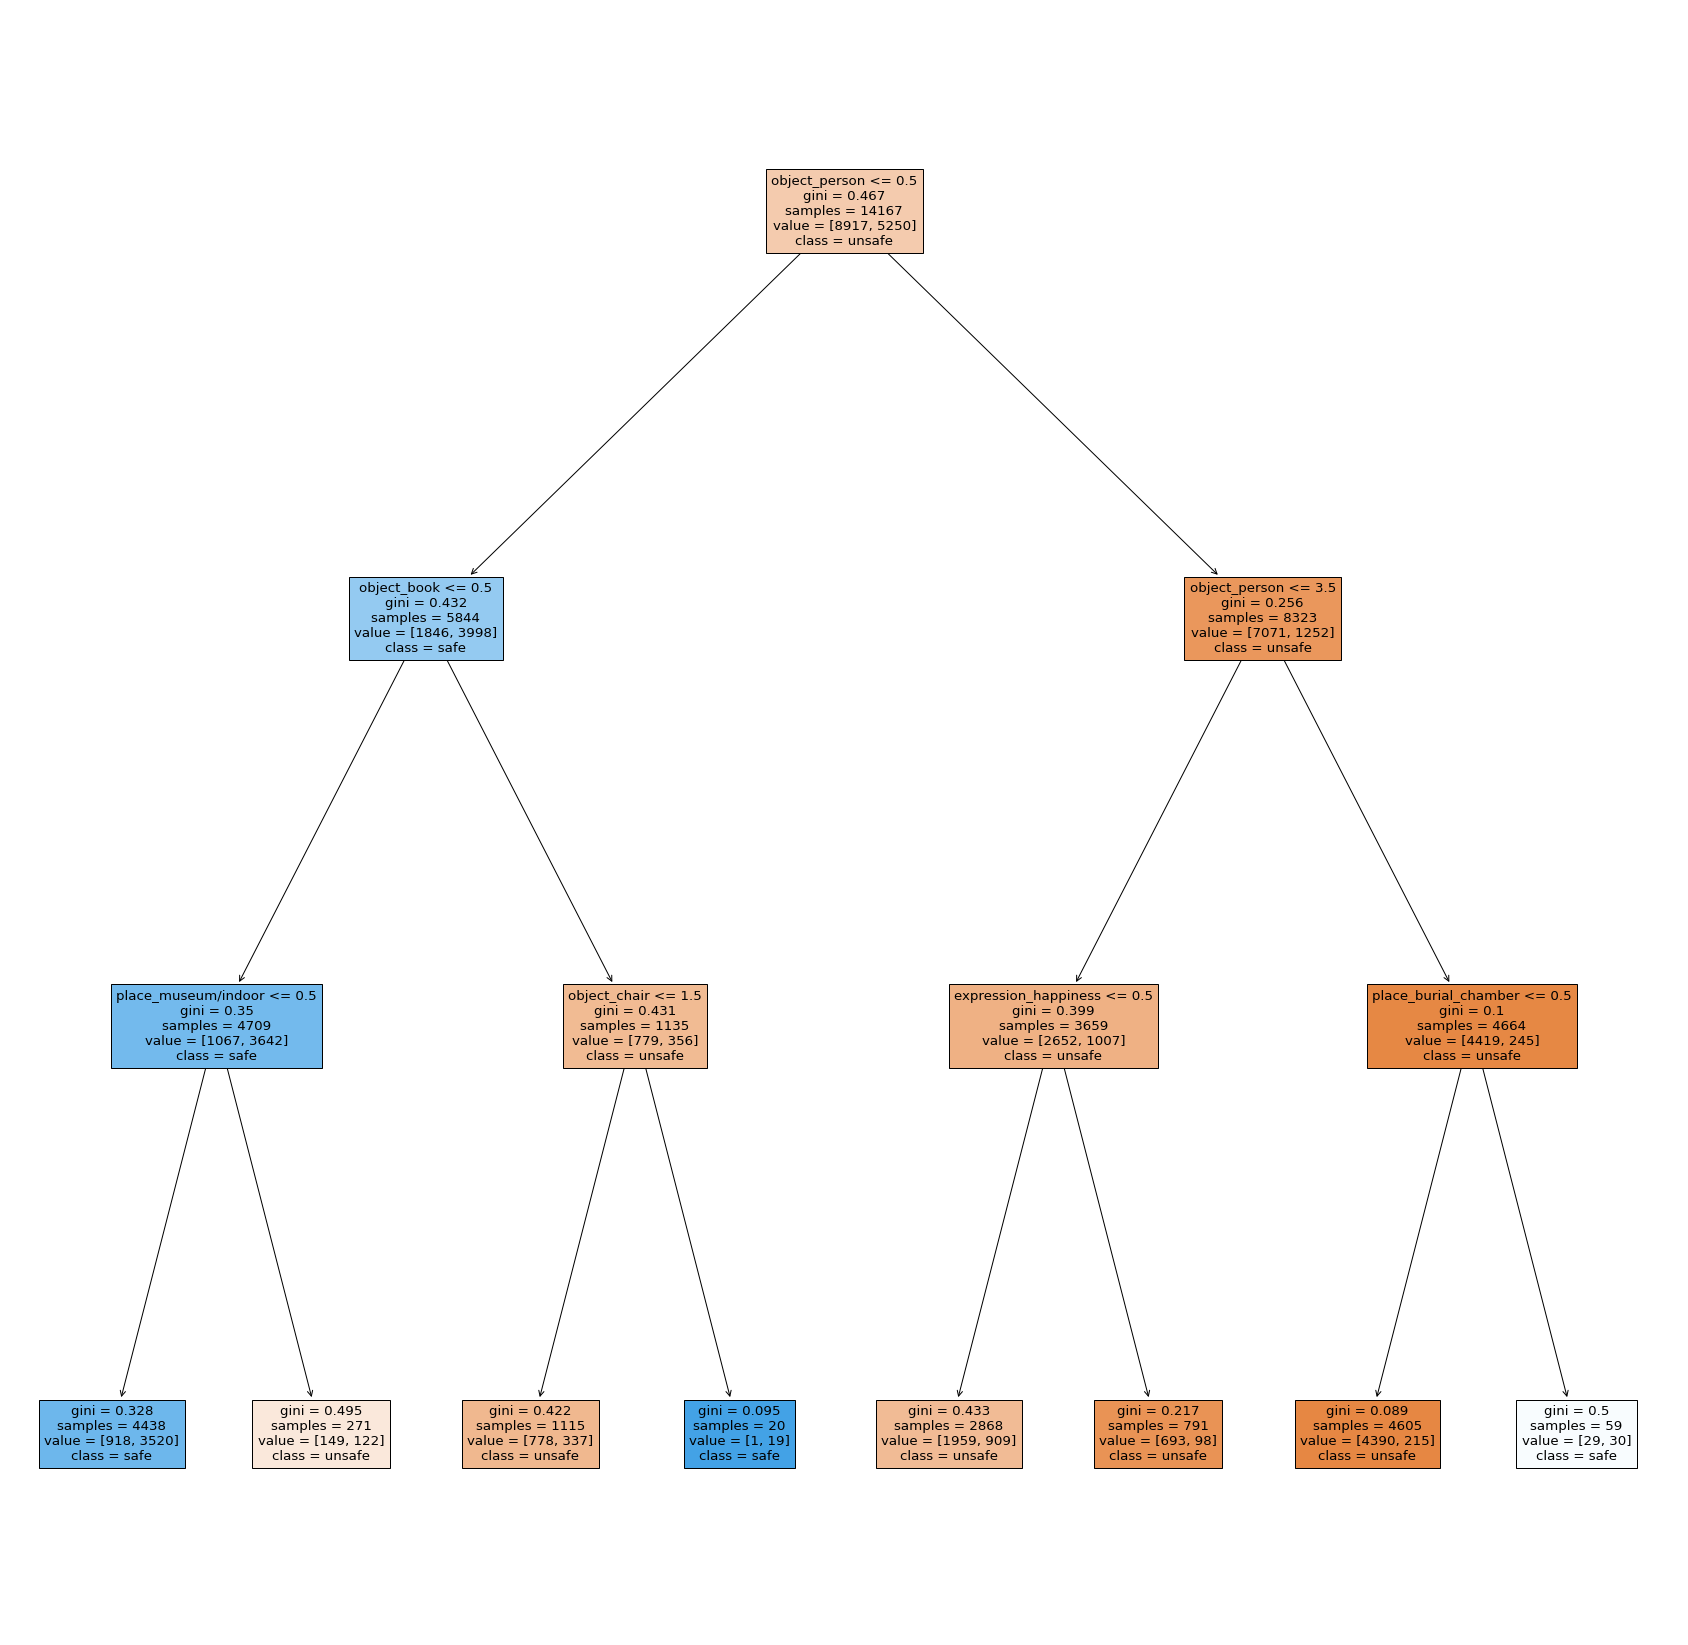

In [28]:
fig = plt.figure(figsize=(30, 30))
_ = tree.plot_tree(
    clf,
    feature_names=X_train.columns,
    class_names=["unsafe", "safe"],
    filled=True
)

In [29]:
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.86      0.89      0.87      4994
        True       0.81      0.75      0.78      3006

    accuracy                           0.84      8000
   macro avg       0.83      0.82      0.83      8000
weighted avg       0.84      0.84      0.84      8000



## SVM

In [30]:
from sklearn.svm import SVC

In [31]:
clf = SVC()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.87      0.83      0.85      4994
        True       0.74      0.80      0.77      3006

    accuracy                           0.82      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.82      0.82      0.82      8000



## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.84      0.91      0.88      4994
        True       0.83      0.72      0.77      3006

    accuracy                           0.84      8000
   macro avg       0.84      0.82      0.82      8000
weighted avg       0.84      0.84      0.84      8000

